# Rat 05 forward model with linear elasticity

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


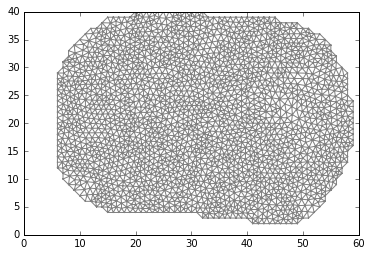

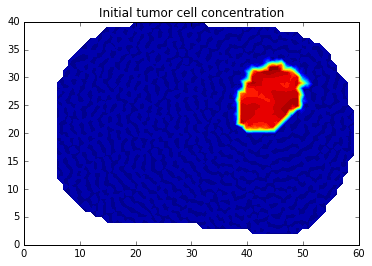

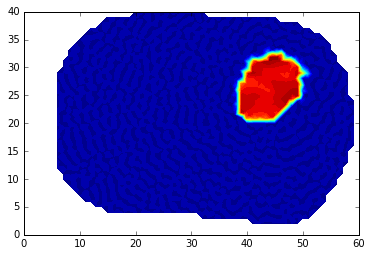

In [5]:
%matplotlib inline
from fenics import *
import numpy as np
np.set_printoptions(threshold=np.inf)
import scipy
import scipy.io
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import time
import os 
import sys
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import rd
import le
from xdmf_parser import xparse as xp

class InterpolatedParameter(Expression):
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)

# Create mesh and define function spaces
mesh = Mesh("./rat-data/rat05/gmsh.xml")
plot(mesh)
cf = MeshFunction("size_t",mesh,"./rat-data/rat05/gmsh_physical_region.xml")
V = VectorFunctionSpace(mesh, 'P', 2)
W = FunctionSpace(mesh, 'P',1) # Function space for tumor cells

# Load initial tumor condition data
tumor = scipy.io.loadmat("./rat-data/rat05/ic.mat")['ic']
tumor = np.fliplr(tumor.T)
x,y = tumor.shape[0], tumor.shape[1]
phi_0 = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),tumor,degree=1)
phi_n = project(phi_0,W) #use the fenics project function to apply the interpolation to the DOFs

plt.figure()
plot(phi_n,title="Initial tumor cell concentration")

# Variables
T = 1            # final time
num_steps = 100     # number of time steps
dt = T / num_steps # time step size
Dt = 100.          # Diffusion coefficient
alphat = 2.5       # Reaction coeffecient
gamma1 = 10.       # stress-to-diffusion coefficient
gamma2 = 10.       # stress-to-reaction coefficient
mu = 1.0           # Shear modulus
lam = 1.0          # lame parameter
nu = lam/(2*(lam+mu)) # Poisson's ratio
beta = 1      # tumor coefficient
omega = 2*mu*beta+3*lam*beta # alternative formulation constant

# Define expressions and functions used in variational forms
D = project(Constant(Dt),W)   # Parameter 1
alpha = project(Constant(alphat),W)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

T = Expression((('0','0'),('0','0')),degree=1)
n = FacetNormal(mesh)

# Compare with alternative formulation
os.system('rm ./output/rat05/*')
phifile = XDMFFile('./output/rat05/solution.xdmf')
u = Function(V)
vm = Function(W)
phi = Function(W)
u.rename("disp","")
vm.rename("vonmises","")
phi.rename("phi","")
t = 0.0
for i in range(num_steps):
    t += dt
    u = le.varprob1(V, W, T, n, bc, phi_n, mu, lam, beta)
    vm = le.vm1(u, W, phi_n, mu, lam, beta)
    D = Dt*exp(-gamma1*vm)
    alpha = alphat*exp(-gamma2*vm)
    phi = rd.varprob(dt, W, phi_n, D, alpha)
    
    # Update previous solution
    phi_n.assign(phi)
    
    # Save solution to file (xdmf)
    phifile.write(u,t)
    phifile.write(vm,t)
    phifile.write(phi,t)
    
del phifile
plt.figure()
plot(phi_n)
xp("output/rat05/solution.xdmf")


# Inverse Problem

In [ ]:
%matplotlib inline
from fenics import *
from fenics_adjoint import *
import numpy as np
np.set_printoptions(threshold=np.inf)
import scipy
import scipy.io
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import time
import os 
import sys
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
import rd
import le
from xdmf_parser import xparse as xp

class InterpolatedParameter(Expression):
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)

# Create mesh and define function spaces
mesh = Mesh("./rat-data/rat05/rat05gmsh.xml")
cf = MeshFunction("size_t",mesh,"./rat-data/rat05/rat05gmsh_physical_region.xml")
V = VectorFunctionSpace(mesh, 'P', 2)
W = FunctionSpace(mesh, 'P',1) # Function space for tumor cells
tumor = scipy.io.loadmat("./rat-data/rat05/rat05ic.mat")['rat05ic']
tumor = np.fliplr(tumor.T)

x = tumor.shape[0]
y = tumor.shape[1]
phi_0 = InterpolatedParameter(np.linspace(1,x,x),np.linspace(1,y,y),tumor,degree=1)
phi_n = project(phi_0,W) #use the fenics interpolate function to apply the interpolation to the DOFs
plt.figure()
plot(phi_n,title="Initial tumor cell concentration")

# Variables
T = .1            # final time
num_steps = 20     # number of time steps
dt = T / num_steps # time step size
Dt = .05           # Diffusion coefficient
alphat = 2.5       # Reaction coeffecient
gamma1 = 10.       # stress-to-diffusion coefficient
gamma2 = 10       # stress-to-reaction coefficient
mu = 1.0           # Shear modulus
lam = 1.0          # lame parameter
nu = lam/(2*(lam+mu)) # Poisson's ratio
beta = .001      # tumor coefficient
omega = 2*mu*beta+3*lam*beta # alternative formulation constant

# Define expressions and functions used in variational forms
D = project(Constant(Dt),W)   # Parameter 1
alpha = project(Constant(alphat),W)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

T = Expression((('0','0'),('0','0')),degree=1)
n = FacetNormal(mesh)

# Compare with alternative formulation
os.system('rm ./output/rat05/*')
phifile = XDMFFile('./output/rat05/solution.xdmf')
u = Function(V)
vm = Function(W)
phi = Function(W)
u.rename("disp","")
vm.rename("vonmises","")
phi.rename("phi","")
t = 0
for i in range(num_steps):
    t += dt
    u = le.varprob1(V, W, T, n, bc, phi_n, mu, lam, beta)
    vm = le.vm1(u, W, phi_n, mu, lam, beta)
    D = Dt*exp(-gamma1*vm)
    alpha = alphat*exp(-gamma2*vm)
    phi = rd.varprob(dt, W, phi_n, D, alpha)
    
    # Update previous solution
    phi_n.assign(phi)
    
    # Save solution to file (xdmf)
    phifile.write(u,t)
    phifile.write(vm,t)
    phifile.write(phi,t)
    
del phifile
plt.figure()
plot(phi_n)
xp("output/rat05/solution.xdmf")
